# Quantifying uncertainties in 2D seismic wave propagation
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/medicinely/fwi/blob/main/vae_keras_gaussian2d.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
    
  <td>
    <a target="_blank" href="https://github.com/medicinely/fwi/blob/main/vae_keras_gaussian2d.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

In [1]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

## Import libraries

In [1]:
# import sys, importlib
# importlib.reload(sys.modules['med.func.inversion'])
# importlib.reload(sys.modules['func.propagation_tf'])

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time

from func.propagation import prop2d, defmodel
from func.propagation_tf import simulate_obs
from func.inversion import gradiant
# from func.velocity_model import check_model, gaussian2d

2022-12-12 16:48:56.729981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 16:48:57.193184: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-12 16:48:57.238030: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-12 16:48:57.238061: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Calcualte d_obs

dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  28 28 235
Number of receivers: 10


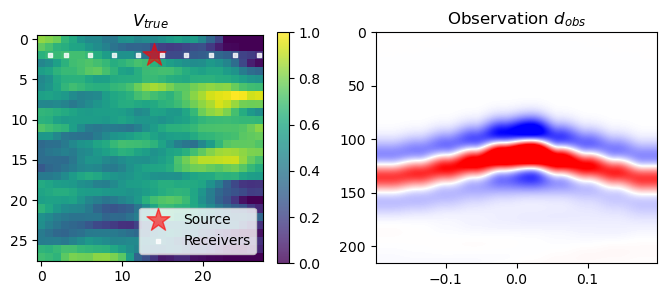

In [2]:
# Import true model and observation
import pickle
filename = './data/v_ref'
infile = open(filename, 'rb')
v_ref = pickle.load(infile)
infile.close()

filename = './data/d_obs'
infile = open(filename, 'rb')
d_obs = pickle.load(infile)
infile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 28,28,235

vmin,vmax=2000,3000
az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=[nz//10], ixsrc=[nx//2],  # define source coordinates z, x
                      ext=10)  

# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
nrec = 10 # number of receivers per well
receivers_width = np.linspace(1,nx-1,num=nrec, endpoint=True, dtype=int)
zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
print("Number of receivers:", len(zxrec.flatten())//2)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(v_ref)
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.colorbar()
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

################# New observation ################
# Simulate real observation
# p = prop2d(wsrc,zxsrc,v_ref,at,az,ax,next,device='cpu')
# print("shape of p(z,x,t) =", p.shape)
# d_obs = p[zxrec[0], zxrec[1], :]

## Functions - tf 2D propagation

## $Gradiant  = \frac{\mathrm{d} J}{\mathrm{d} v}$

2022-12-12 16:49:12.037217: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-12 16:49:12.037247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (himalaya-fon): /proc/driver/nvidia/version does not exist
2022-12-12 16:49:12.039329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Total time 00h 00m 03s
J = 77.9538269043
gradient shape: (28, 28)


Text(0.5, 1.0, 'Gradient of initial V')

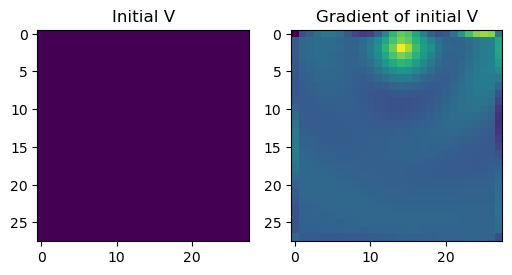

In [3]:
v = tf.Variable(tf.convert_to_tensor(np.zeros([nz, nx]) + 2500,dtype="float32"))
with tf.GradientTape() as tape:
	tape.watch(v)
	start = time.time()
	d = new_func(v)
	print('Total time',time.strftime("%Hh %Mm %Ss", time.gmtime(time.time()-start)))
	# Calculate loss "J"
	loss = .5 * tf.reduce_sum((d - d_obs)**2)
	print("J = %.10f" % loss.numpy())
g = tape.gradient(loss, v)
print("gradient shape:", g.shape)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(v)
plt.title("Initial V")
plt.subplot(1,2,2)
plt.imshow(g)
plt.title("Gradient of initial V")

Text(0.5, 1.0, 'adjoint')

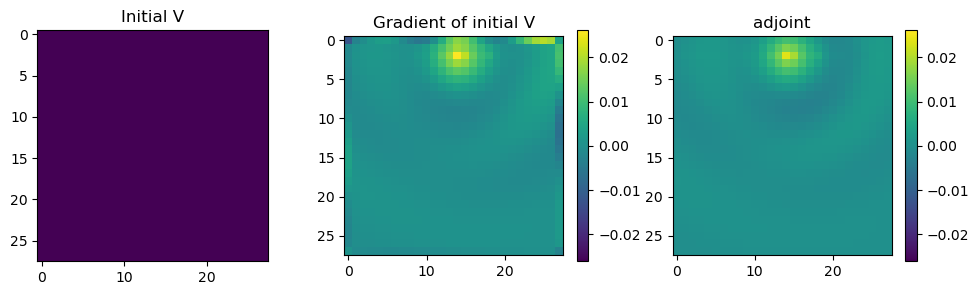

In [5]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.imshow(v)
plt.title("Initial V")
plt.subplot(1,3,2)
maxi = np.max(abs(g))
plt.imshow(g,vmin=-maxi,vmax=+maxi)
plt.colorbar()
plt.title("Gradient of initial V")
plt.subplot(1,3,3)
g_adj = gradiant(v.numpy(),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device='cpu').reshape(nz,nz)
plt.imshow(g_adj,vmin=-maxi,vmax=+maxi)
plt.colorbar()
plt.title("adjoint")

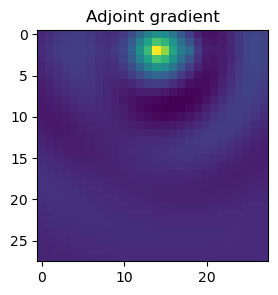

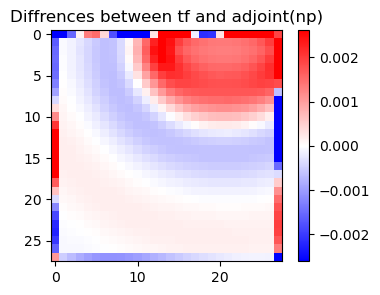

In [6]:
plt.figure(figsize=(3,3))
plt.title("Adjoint gradient")
plt.imshow(g_adj)
p = prop2d(wsrc,zxsrc,v,at,az,ax,next,device='cpu')
d = p[zxrec[0], zxrec[1], :]
J = .5 * np.sum((d - d_obs)**2)
# print("np J =",loss.numpy())

plt.figure(figsize=(4,3))
plt.title("Diffrences between tf and adjoint(np)")
plt.imshow(g-g_adj,vmin=-maxi/10,vmax=+maxi/10,cmap="bwr")
plt.colorbar()

## Sampling (latent space)

In [9]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder

In [10]:
latent_dim = 2
img_width, img_height = 28,28
# acfunc = "tanh" #relu
# acfunc2 = "tanh" #sigmoid
acfunc = "relu" 
acfunc2 = "sigmoid" 

encoder_inputs = keras.Input(shape=(img_width, img_height, 1))
x = layers.Conv2D(32, 3, activation=acfunc, strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation=acfunc, strides=2, padding="same")(x)
conv_shape = x.shape
x = layers.Flatten()(x)
x = layers.Dense(16, activation=acfunc)(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

## Decoder

In [11]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation=acfunc)(latent_inputs)
x = layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = layers.Conv2DTranspose(64, 3, activation=acfunc, strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation=acfunc, strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation=acfunc2, padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

## Train the VAE

Epoch 1/5000
1/1 [==============================] - 0s 101ms/step - loss: 362.6271 - reconstruction_loss: 362.6271 - kl_loss: 4.5180e-05
Epoch 2/5000
1/1 [==============================] - 0s 63ms/step - loss: 361.7707 - reconstruction_loss: 361.7706 - kl_loss: 4.7654e-05
Epoch 3/5000
1/1 [==============================] - 0s 58ms/step - loss: 360.6534 - reconstruction_loss: 360.6533 - kl_loss: 4.8161e-05
Epoch 4/5000
1/1 [==============================] - 0s 57ms/step - loss: 359.2526 - reconstruction_loss: 359.2526 - kl_loss: 5.1498e-05
Epoch 5/5000
1/1 [==============================] - 0s 50ms/step - loss: 358.3984 - reconstruction_loss: 358.3983 - kl_loss: 5.4836e-05
Epoch 6/5000
1/1 [==============================] - 0s 50ms/step - loss: 358.0114 - reconstruction_loss: 358.0113 - kl_loss: 5.8353e-05
Epoch 7/5000
1/1 [==============================] - 0s 57ms/step - loss: 357.2823 - reconstruction_loss: 357.2823 - kl_loss: 6.2585e-05
Epoch 8/5000
1/1 [=============================

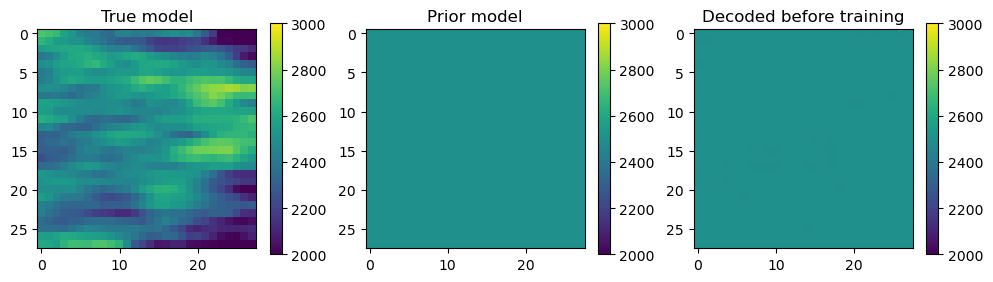

In [15]:
# Set prior velocity field (28,28)
prior = np.zeros([nz, nx]) + 2500
# prior = v_ref
prior = prior/3000
prior = prior.reshape(1,img_width,img_height,1)

class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(
        name="reconstruction_loss"
    )
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker,
    ]

  def train_step(self, data):
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + 1*kl_loss
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(prior, epochs=5000, batch_size=1, verbose=1)

# Decode prior to latent prior distribution
mu, sig, z = vae.encoder.predict(prior)
input = prior.reshape(img_width,img_height)
output = vae.decoder.predict(mu).reshape(img_width,img_height)
# Re-scale the image
input = input*3000
output = output*3000
loss = np.abs(input - output)/(nz*nx)
print("Average loss:",loss.sum())


plt.figure(figsize=(12,3))
# output image
plt.subplot(1,3,1)
print("Reference mean:",v_ref.mean())
plt.imshow(v_ref,vmin=2000,vmax=3000)
plt.colorbar()
plt.title("True model")

# Input image
plt.subplot(1,3,2)
print("Input mean:",input.mean())
plt.imshow(input,vmin=2000,vmax=3000)
plt.colorbar()
plt.title("Prior model")

# output image
plt.subplot(1,3,3)
print("Output mean:",output.mean())
plt.imshow(output,vmin=2000,vmax=3000)
plt.colorbar()
plt.title("Decoded before training")
plt.show()

## Define the VAE as a `Model` with a custom `train_step`

In [23]:
# Start training
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.loss_tracker = keras.metrics.Mean(name="loss")
  @property
  def metrics(self):
    return [
        self.loss_tracker,
    ]

  def train_step(self, data):
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        v = 3000 * tf.reshape(reconstruction,[nz,nx])
        d = simulate_obs(v, wsrc, zxsrc, at, az, ax, next, zxrec)
        loss = .5 * tf.reduce_sum((d - d_obs)**2)
    grads = tape.gradient(loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.loss_tracker.update_state(loss)
    return {
        "loss": self.loss_tracker.result(),
    }
opt = keras.optimizers.Adam(learning_rate=0.0000001)
vae = VAE(vae.encoder, vae.decoder)
vae.compile(optimizer=opt, run_eagerly=True)
vae.fit(prior, epochs=50, batch_size=1, verbose=1)

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 28.5973
Epoch 2/50
1/1 [==============================] - 5s 5s/step - loss: 29.2440
Epoch 3/50
1/1 [==============================] - 6s 6s/step - loss: 28.8049
Epoch 4/50
1/1 [==============================] - 5s 5s/step - loss: 29.6502
Epoch 5/50
1/1 [==============================] - 5s 5s/step - loss: 28.0596
Epoch 6/50
1/1 [==============================] - 5s 5s/step - loss: 28.4366
Epoch 7/50
1/1 [==============================] - 5s 5s/step - loss: 28.3187
Epoch 8/50
1/1 [==============================] - 5s 5s/step - loss: 27.7382
Epoch 9/50
1/1 [==============================] - 5s 5s/step - loss: 29.4737
Epoch 10/50
1/1 [==============================] - 6s 6s/step - loss: 29.1053
Epoch 11/50
1/1 [==============================] - 6s 6s/step - loss: 30.6796
Epoch 12/50
1/1 [==============================] - 6s 6s/step - loss: 28.9121
Epoch 13/50
1/1 [==============================] - 6s 6s/step - loss: 28.

## Generate new image

1/1 [==============================] - 0s 22ms/step
Average loss: 82.98417756995376
Input mean: 2500.0


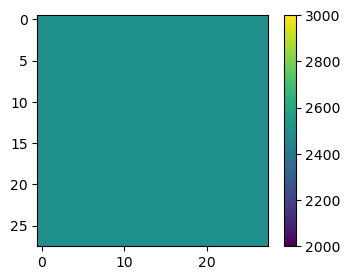

Output mean: 2417.2612


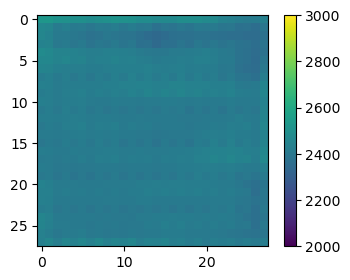

In [22]:
mu, sig, z = vae.encoder.predict(prior)
input = prior.reshape(img_width,img_height)
output = vae.decoder.predict(z).reshape(img_width,img_height)
# Re-scale the image
input = input*3000
output = output*3000
loss = np.abs(input - output)/(nz*nx)
print("Average loss:",loss.sum())
# Input image
plt.figure(figsize=(4,3))
# plt.subplot(1,2,1)
print("Input mean:",input.mean())
plt.imshow(input,vmin=2000,vmax=3000)
plt.colorbar()
plt.show()
# output image
plt.figure(figsize=(4,3))
# plt.subplot(1,2,2)
print("Output mean:",output.mean())
plt.imshow(output,vmin=2000,vmax=3000)
plt.colorbar()
plt.show()

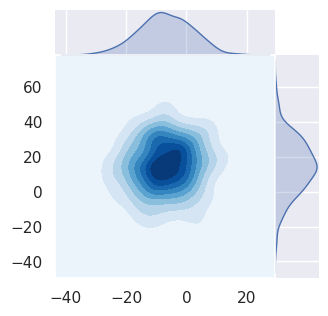

In [ ]:
def show_posterior(mu,sig):
  mean = [mu[0,0], mu[0,1]]
  cov = [[sig[0,0]**2, 0], [0, mu[0,1]**2]]

  x, y = np.random.multivariate_normal(mean, cov, 500).T
  # sns.set_style("darkgrid")
  ax = sns.jointplot(x=x,y=y,kind="kde",space=0,fill=True,
                    thresh=0,cmap='Blues',joint_kws={'alpha': 1})
  ax.fig.set_size_inches(3,3)

show_posterior(mu,sig)